In [30]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)


Using TensorFlow backend.


In [31]:
#to read
def read_data(filename):
    file= open(filename,mode="rt",encoding='UTF-8')#TO OPEN
    text = file.read()
    file.close()
    return text
    
    

In [32]:
def to_lines(text):
      sents = text.strip().split('\n') #formed sentences
      sents = [i.split('\t') for i in sents]
      return sents

In [46]:
file = read_data("deu.txt")
ger_eng = to_lines(file)
ger_eng=array(ger_eng)#converted to array

ger_eng = ger_eng[:50000,:2]#we ned 1st 5000 rows
print(ger_eng)



[['Go.' 'Geh.']
 ['Hi.' 'Hallo!']
 ['Hi.' 'Grüß Gott!']
 ...
 ['Who else is in there?' 'Wer ist noch dort drin?']
 ['Who else was in here?' 'Wer war sonst noch hier drin?']
 ['Who fixed the window?' 'Wer hat das Fenster hergerichtet?']]


In [47]:
ger_eng

array([['Go.', 'Geh.'],
       ['Hi.', 'Hallo!'],
       ['Hi.', 'Grüß Gott!'],
       ...,
       ['Who else is in there?', 'Wer ist noch dort drin?'],
       ['Who else was in here?', 'Wer war sonst noch hier drin?'],
       ['Who fixed the window?', 'Wer hat das Fenster hergerichtet?']],
      dtype='<U537')

In [48]:
#Text Pre-Processing
#cleaning
# Remove punctuation
ger_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in ger_eng[:,0]]
ger_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in ger_eng[:,1]]

In [49]:
print(ger_eng)

[['Go' 'Geh']
 ['Hi' 'Hallo']
 ['Hi' 'Grüß Gott']
 ...
 ['Who else is in there' 'Wer ist noch dort drin']
 ['Who else was in here' 'Wer war sonst noch hier drin']
 ['Who fixed the window' 'Wer hat das Fenster hergerichtet']]


In [50]:
print(len(ger_eng))

50000


In [52]:
for i in range(len(ger_eng)):
    ger_eng[i,0] = ger_eng[i,0].lower()
    ger_eng[i,1] = ger_eng[i,1].lower()

In [63]:
# Text to Sequence Conversion

#A Seq2Seq model requires that we convert both the input and the output sentences into integer sequences of fixed length.
#spliting german englidh pair to german and english seperate pairs
#initialize empty list
# populate the lists with sentence lengths
ger=[]
eng =[]
for i in ger_eng[:,0]:
      eng.append(len(i.split()))

for i in ger_eng[:,1]:
      ger.append(len(i.split()))

    

In [64]:
ger

[1,
 1,
 2,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 1,
 1,
 2,
 1,
 3,
 4,
 2,
 2,
 1,
 3,
 3,
 3,
 3,
 2,
 1,
 1,
 1,
 2,
 2,
 3,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 1,
 2,
 1,
 2,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 5,
 2,
 4,
 2,
 3,
 2,
 3,
 3,
 2,
 3,
 2,
 3,
 3,
 3,
 2,
 2,
 2,
 3,
 2,
 2,
 3,
 5,
 3,
 3,
 4,
 3,
 3,
 2,
 1,
 5,
 4,
 1,
 3,
 1,
 1,
 2,
 1,
 1,
 1,
 3,
 3,
 2,
 2,
 3,
 2,
 1,
 2,
 3,
 2,
 2,
 2,
 3,
 2,
 2,
 1,
 1,
 3,
 2,
 4,
 2,
 2,
 2,
 2,
 2,
 3,
 2,
 3,
 3,
 3,
 2,
 2,
 3,
 2,
 3,
 2,
 1,
 1,
 1,
 2,
 2,
 2,
 3,
 2,
 2,
 3,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 3,
 2,
 4,
 2,
 2,
 2,
 2,
 2,
 3,
 2,
 3,
 3,
 3,
 3,
 2,
 2,
 2,
 1,
 1,
 3,
 2,
 4,
 2,
 2,
 2,
 2,
 2,
 3,
 2,
 3,
 3,
 3,
 3,
 3,
 2,
 2,
 2,
 1,
 2,
 1,
 2,
 3,
 3,
 2,
 2,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 3,
 2,
 1,
 2,
 2,
 3,
 2,
 3,
 2,
 3,
 2,
 2,
 3,
 2,
 3,
 2,
 3,
 2,
 3,
 2,
 3,
 2,
 3,
 2,
 2,
 3,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 2,
 2,
 2,
 2,


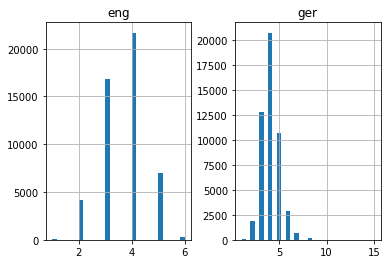

In [66]:

length_df = pd.DataFrame({'eng':eng, 'ger':ger}) #converting to pd dataframe

length_df.hist(bins = 30)#ploting histogram
plt.show()

In [67]:
# function to build a tokenizer
def tokenization(lines):
      tokenizer = Tokenizer()
      tokenizer.fit_on_texts(lines)
      return tokenizer